In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.naive_bayes import GaussianNB, MultinomialNB
from sklearn.neighbors import NearestCentroid
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import BaggingClassifier
from sklearn.datasets import make_blobs
from datetime import datetime
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn import svm
from xgboost import XGBRegressor
from sklearn import metrics
from sklearn.metrics import r2_score

In [2]:
from google.cloud import bigquery
from google.oauth2 import service_account
credentials = service_account.Credentials.from_service_account_file(
'hg-analytics-316512-709a9ea9b180.json')
project_id = 'hg-analytics-316512'
client = bigquery.Client(credentials= credentials,project=project_id)

In [3]:
query_job = client.query("""
select * from `datawarehouse_prod.dim_market` """) 
dim_market= query_job.to_dataframe()
query_job = client.query("""
select * from `datawarehouse_prod.dim_campaign` """) 
dim_campaign = query_job.to_dataframe()
query_job = client.query("""
select * from `datawarehouse_prod.dim_channel` """) 
dim_channel = query_job.to_dataframe()
query_job = client.query("""
select * from `datawarehouse_prod.dim_date` """) 
dim_date = query_job.to_dataframe()
query_job = client.query("""
select * from `datawarehouse_prod.dim_platform` """) 
dim_platform = query_job.to_dataframe()

In [ ]:
query_job = client.query("""
select coalesce(key_market,market) as market,conversion.*,full_date from `datawarehouse_prod.fact_conversion` conversion 
left join `datawarehouse_prod.dim_channel` channel on channel.key_channel=conversion.key_channel 
 left join `datawarehouse_dev.dim_campaign` campaign on campaign.master_campaign_id=conversion.key_campaign
 left join `datawarehouse_prod.dim_date` date on date.key_date=conversion.key_date
where channel_type='Digital' and activity<>"Hurtigruten Global Page" and key_campaign is not null
and key_campaign is not null ;    
 """) 
fact_conversion = query_job.to_dataframe()

In [ ]:
fact_conversion.head()

In [ ]:
#tactic column has some values in caps,converting to standard form
correction_dict = {
    'GLOBAL': 'Global'
    # Add more incorrect-correct pairs as needed
}

fact_conversion['market'] = fact_conversion['market'].replace(correction_dict)

In [ ]:
fact_conversion.isna().sum()

In [114]:
campaign = pd.DataFrame(fact_conversion['market'].unique())
campaign.columns = ['market']


In [115]:
max_date = fact_conversion.groupby('market').full_date.max().reset_index()
max_date.columns = ['market','latestdate']

In [116]:
import datetime

max_date['max_date'] = max_date['latestdate'].max()
max_date['Recency'] = (max_date['max_date'] - max_date['latestdate']).dt.days

max_date['Recency'] = max_date['Recency'].astype(int)


In [117]:
campaign = pd.merge(campaign, max_date[['market','Recency']], on='market')

In [118]:
campaign

,market,Recency
0,Norway,0
1,Sweden,0
2,Switzerland,0
3,Denmark,0
4,Other APAC,0
5,Australia,0
6,AP,1
7,Germany,0
8,France,0
9,United States,0


In [119]:
import plotly.graph_objs as go
import plotly.offline as pyoff


plot_data = [
    go.Histogram(
        x=campaign['Recency']
    )
]

plot_layout = go.Layout(
        title='Recency'
    )
fig = go.Figure(data=plot_data, layout=plot_layout)
pyoff.iplot(fig)

In [120]:
campaign.Recency.describe()

count     17.000000
mean      12.882353
std       52.858162
min        0.000000
25%        0.000000
50%        0.000000
75%        0.000000
max      218.000000
Name: Recency, dtype: float64

C:\Users\Rajeev Kumar Badhwar\anaconda4\lib\site-packages\sklearn\cluster\_kmeans.py:1036: UserWarning:

KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.



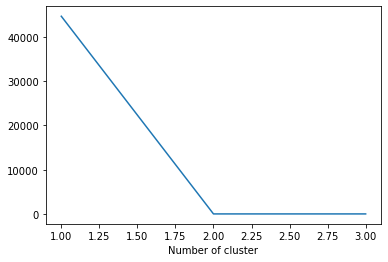

In [121]:
from sklearn.cluster import KMeans

sse={}
tx_recency = campaign[['Recency']]
for k in range(1, 4):
    kmeans = KMeans(n_clusters=k, max_iter=100).fit(tx_recency)
    tx_recency["clusters"] = kmeans.labels_
    sse[k] = kmeans.inertia_ 
plt.figure()
plt.plot(list(sse.keys()), list(sse.values()))
plt.xlabel("Number of cluster")
plt.show()

In [122]:
#build 4 clusters for recency and add it to dataframe
kmeans = KMeans(n_clusters=2)
kmeans.fit(campaign[['Recency']])
campaign['RecencyCluster'] = kmeans.predict(campaign[['Recency']])

#function for ordering cluster numbers
def order_cluster(cluster_field_name, target_field_name,df,ascending):
    new_cluster_field_name = 'new_' + cluster_field_name
    df_new = df.groupby(cluster_field_name)[target_field_name].mean().reset_index()
    df_new = df_new.sort_values(by=target_field_name,ascending=ascending).reset_index(drop=True)
    df_new['index'] = df_new.index
    df_final = pd.merge(df,df_new[[cluster_field_name,'index']], on=cluster_field_name)
    df_final = df_final.drop([cluster_field_name],axis=1)
    df_final = df_final.rename(columns={"index":cluster_field_name})
    return df_final

campaign = order_cluster('RecencyCluster', 'Recency',campaign,False)

In [123]:
campaign

,market,Recency,RecencyCluster
0,Norway,0,1
1,Sweden,0,1
2,Switzerland,0,1
3,Denmark,0,1
4,Other APAC,0,1
5,Australia,0,1
6,AP,1,1
7,Germany,0,1
8,France,0,1
9,United States,0,1


In [124]:
#get order counts for each user and create a dataframe with it
tx_frequency = fact_conversion.groupby('market')['total_conversions'].sum().reset_index()

tx_frequency.columns = ['market','Frequency']

#add this data to our main dataframe
campaign = pd.merge(campaign, tx_frequency, on='market')
campaign


,market,Recency,RecencyCluster,Frequency
0,Norway,0,1,276949
1,Sweden,0,1,85583
2,Switzerland,0,1,28888
3,Denmark,0,1,72291
4,Other APAC,0,1,29473
5,Australia,0,1,4338
6,AP,1,1,2860
7,Germany,0,1,350218
8,France,0,1,92376
9,United States,0,1,94011


In [125]:
#plot the histogram
plot_data = [
    go.Histogram(
        x=campaign['Frequency']
    )
]

plot_layout = go.Layout(
        title='Frequency'
    )
fig = go.Figure(data=plot_data, layout=plot_layout)
pyoff.iplot(fig)

In [126]:
#k-means
kmeans = KMeans(n_clusters=5)
kmeans.fit(campaign[['Frequency']])
campaign['FrequencyCluster'] = kmeans.predict(campaign[['Frequency']])

#order the frequency cluster
campaign = order_cluster('FrequencyCluster', 'Frequency',campaign,True)

#see details of each cluster
campaign.groupby('FrequencyCluster')['Frequency'].describe()

,count,mean,std,min,25%,50%,75%,max
FrequencyCluster,,,,,,,,
0,7.0,4878.571429,3163.471398,1878.0,3073.0,4311.0,5214.5,11386.0
1,3.0,26653.333333,4386.943165,21599.0,25243.5,28888.0,29180.5,29473.0
2,4.0,86065.25,9881.346682,72291.0,82260.0,88979.5,92784.75,94011.0
3,1,276949.0,<NA>,276949,276949,276949,276949,276949
4,2.0,337848.0,17493.821767,325478.0,331663.0,337848.0,344033.0,350218.0


In [127]:
#calculate revenue for each customer

tx_revenue = fact_conversion.groupby('market')['revenue_local'].sum().reset_index()

#merge it with our main dataframe
campaign = pd.merge(campaign, tx_revenue, on='market')


In [128]:

#plot the histogram
plot_data = [
    go.Histogram(
        x=campaign['revenue_local']
    )
]

plot_layout = go.Layout(
        title='Monetary Value'
    )
fig = go.Figure(data=plot_data, layout=plot_layout)
pyoff.iplot(fig)

In [129]:
#apply clustering
kmeans = KMeans(n_clusters=5)
kmeans.fit(campaign[['revenue_local']])
campaign['RevenueCluster'] = kmeans.predict(campaign[['revenue_local']])


#order the cluster numbers
campaign = order_cluster('RevenueCluster', 'revenue_local',campaign,True)

#show details of the dataframe
campaign.groupby('RevenueCluster')['revenue_local'].describe()

,count,unique,top,freq
RevenueCluster,,,,
0,7,7,174310.000000000,1
1,5,5,2042386.000000000,1
2,3,3,6003897.320000000,1
3,1,1,8749744.500000000,1
4,1,1,51472778.150000000,1


In [130]:
campaign

,market,Recency,RecencyCluster,Frequency,FrequencyCluster,revenue_local,RevenueCluster
0,Norway,0,1,276949,3,51472778.150000000,4
1,Sweden,0,1,85583,2,8749744.500000000,3
2,Denmark,0,1,72291,2,2042386.000000000,1
3,France,0,1,92376,2,1788989.370000000,1
4,Switzerland,0,1,28888,1,1500988.000000000,1
5,Other APAC,0,1,29473,1,2280851.000000000,1
6,Global,218,0,21599,1,2731951.000000000,1
7,United States,0,1,94011,2,6003897.320000000,2
8,Germany,0,1,350218,4,6412530.270000000,2
9,United Kingdom,0,1,325478,4,4896058.350000000,2


In [135]:
campaign['revenue_local']=campaign['revenue_local'].astype(float)
#calculate overall score and use mean() to see details
campaign['OverallScore'] = campaign['RecencyCluster'] + campaign['FrequencyCluster'] + campaign['RevenueCluster']


In [137]:
campaign.groupby('OverallScore')[['Recency','Frequency','revenue_local']].mean()

,Recency,Frequency,revenue_local
OverallScore,,,
1,0.142857,4878.571429,2.769145e+05
2,218.000000,21599.0,2.731951e+06
3,0.000000,29180.5,1.890920e+06
4,0.000000,82333.5,1.915688e+06
5,0.000000,94011.0,6.003897e+06
6,0.000000,85583.0,8.749744e+06
7,0.000000,337848.0,5.654294e+06
8,0.000000,276949.0,5.147278e+07


In [138]:
campaign['Segment'] = 'Low-Value'
campaign.loc[campaign['OverallScore']>2,'Segment'] = 'Mid-Value' 
campaign.loc[campaign['OverallScore']>4,'Segment'] = 'High-Value' 

In [139]:
#Revenue vs Frequency
tx_graph = campaign
plot_data = [
    go.Scatter(
        x=tx_graph.query("Segment == 'Low-Value'")['Frequency'],
        y=tx_graph.query("Segment == 'Low-Value'")['revenue_local'],
        mode='markers',
        name='Low',
        marker= dict(size= 7,
            line= dict(width=1),
            color= 'blue',
            opacity= 0.8
           )
    ),
        go.Scatter(
        x=tx_graph.query("Segment == 'Mid-Value'")['Frequency'],
        y=tx_graph.query("Segment == 'Mid-Value'")['revenue_local'],
        mode='markers',
        name='Mid',
        marker= dict(size= 9,
            line= dict(width=1),
            color= 'green',
            opacity= 0.5
           )
    ),
        go.Scatter(
        x=tx_graph.query("Segment == 'High-Value'")['Frequency'],
        y=tx_graph.query("Segment == 'High-Value'")['revenue_local'],
        mode='markers',
        name='High',
        marker= dict(size= 11,
            line= dict(width=1),
            color= 'red',
            opacity= 0.9
           )
    ),
]

plot_layout = go.Layout(
        yaxis= {'title': "Revenue"},
        xaxis= {'title': "Frequency"},
        title='Segments'
    )
fig = go.Figure(data=plot_data, layout=plot_layout)
pyoff.iplot(fig)

#Revenue Recency



plot_data = [
    go.Scatter(
        x=tx_graph.query("Segment == 'Low-Value'")['Recency'],
        y=tx_graph.query("Segment == 'Low-Value'")['revenue_local'],
        mode='markers',
        name='Low',
        marker= dict(size= 7,
            line= dict(width=1),
            color= 'blue',
            opacity= 0.8
           )
    ),
        go.Scatter(
        x=tx_graph.query("Segment == 'Mid-Value'")['Recency'],
        y=tx_graph.query("Segment == 'Mid-Value'")['revenue_local'],
        mode='markers',
        name='Mid',
        marker= dict(size= 9,
            line= dict(width=1),
            color= 'green',
            opacity= 0.5
           )
    ),
        go.Scatter(
        x=tx_graph.query("Segment == 'High-Value'")['Recency'],
        y=tx_graph.query("Segment == 'High-Value'")['revenue_local'],
        mode='markers',
        name='High',
        marker= dict(size= 11,
            line= dict(width=1),
            color= 'red',
            opacity= 0.9
           )
    ),
]

plot_layout = go.Layout(
        yaxis= {'title': "Revenue"},
        xaxis= {'title': "Recency"},
        title='Segments'
    )
fig = go.Figure(data=plot_data, layout=plot_layout)
pyoff.iplot(fig)

# Revenue vs Frequency


plot_data = [
    go.Scatter(
        x=tx_graph.query("Segment == 'Low-Value'")['Recency'],
        y=tx_graph.query("Segment == 'Low-Value'")['Frequency'],
        mode='markers',
        name='Low',
        marker= dict(size= 7,
            line= dict(width=1),
            color= 'blue',
            opacity= 0.8
           )
    ),
        go.Scatter(
        x=tx_graph.query("Segment == 'Mid-Value'")['Recency'],
        y=tx_graph.query("Segment == 'Mid-Value'")['Frequency'],
        mode='markers',
        name='Mid',
        marker= dict(size= 9,
            line= dict(width=1),
            color= 'green',
            opacity= 0.5
           )
    ),
        go.Scatter(
        x=tx_graph.query("Segment == 'High-Value'")['Recency'],
        y=tx_graph.query("Segment == 'High-Value'")['Frequency'],
        mode='markers',
        name='High',
        marker= dict(size= 11,
            line= dict(width=1),
            color= 'red',
            opacity= 0.9
           )
    ),
]

plot_layout = go.Layout(
        yaxis= {'title': "Frequency"},
        xaxis= {'title': "Recency"},
        title='Segments'
    )
fig = go.Figure(data=plot_data, layout=plot_layout)
pyoff.iplot(fig)


### High Value: Improve Retention
### Mid Value: Improve Retention + Increase Frequency
### Low Value: Increase Frequency

In [140]:
campaign.sort_values(by='OverallScore', ascending=False)


,market,Recency,RecencyCluster,Frequency,FrequencyCluster,revenue_local,RevenueCluster,OverallScore,Segment
0,Norway,0,1,276949,3,51472778.15,4,8,High-Value
9,United Kingdom,0,1,325478,4,4896058.35,2,7,High-Value
8,Germany,0,1,350218,4,6412530.27,2,7,High-Value
1,Sweden,0,1,85583,2,8749744.50,3,6,High-Value
7,United States,0,1,94011,2,6003897.32,2,5,High-Value
3,France,0,1,92376,2,1788989.37,1,4,Mid-Value
2,Denmark,0,1,72291,2,2042386.00,1,4,Mid-Value
4,Switzerland,0,1,28888,1,1500988.00,1,3,Mid-Value
5,Other APAC,0,1,29473,1,2280851.00,1,3,Mid-Value
6,Global,218,0,21599,1,2731951.00,1,2,Low-Value
